## Overview

The goal of this notebook is to design a machine learning model to predict the salary of a job as best as possible from the information in the job description and to interpret it afterwards. The procedure was as follows:

- [Test of a baseline](#baseline)
- [Test of linear models](#linear_models)
- [Test of non-linear models](#non-linear_models)
- [Feature selection](#feature_selection)
- [Interpretation of the results](#interpretation)
- [Summary of the results](#summary)

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, KFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from collections import defaultdict

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/data_wide.csv")
df = df.loc[df["title_category"] != "Others"]
df.dropna(subset=["average_salary"], inplace=True)
df = df.drop(["link", "title", "content", "rating", "num_ratings", "company_link", "release_date"], axis=1)
print(df.shape)
df.head()

(1673, 138)


,company,company_size,permanent_employment,trainee,home_office_possible,part_time,full_time,title_category,experience_level,average_salary,...,creativity,leadership,flexibility,business_focus,initiative,structured_working,3-4_years_experience,<=2_years_experience,>=5_years_experience,no_experience_information
1,BIG direkt gesund,NaN,True,False,True,False,True,Data Science Manager,No Information,59500.0,...,False,False,False,False,False,False,False,False,False,True
2,BIG direkt gesund,NaN,True,False,True,False,True,Data Science Manager,No Information,62500.0,...,False,False,False,False,False,False,False,False,False,True
3,METRO Markets GmbH,NaN,True,False,True,False,True,Data Science Manager,No Information,86000.0,...,False,False,True,False,False,False,False,False,True,False
4,R+V Allgemeine Versicherung AG,"10,001+",True,False,False,False,True,Data Scientist,No Information,61000.0,...,False,False,False,False,True,False,False,False,False,True
8,CHECK24,2501-5000,True,False,True,False,True,Data Science Manager,No Information,78000.0,...,False,True,False,False,False,False,False,False,False,True


After loading the data, irrelevant entries and attributes were first removed from the data set. Subsequently, a test data set is split off from the remaining data, which will later be used to obtain an unbiased estimate of the model quality.

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_train.shape, df_test.shape

((1338, 138), (335, 138))

There are three attributes with missing values. Since all attributes are categorical features, it is easy to add an additional category "missing_value" later.

In [4]:
df_train.isnull().sum().sort_values(ascending=False).head()

company_size     343
main_industry    209
main_region       47
nltk               0
seaborn            0
dtype: int64

The target variable is approximately normally distributed, but contains two relatively extreme outlier. Especially when using a linear model, it can therefore still be useful to transform the target to minimize the effect of the extremely large values and to better approximate the remaining data points.

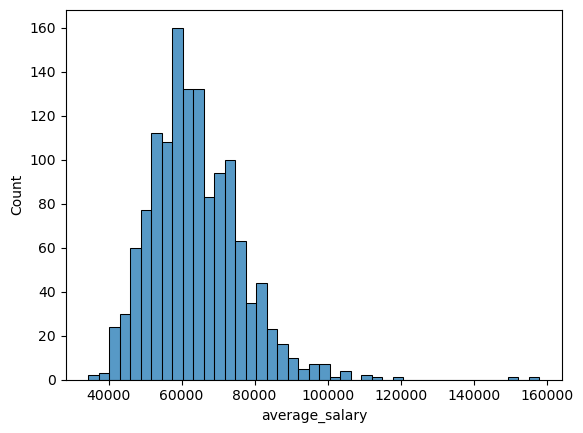

In [5]:
sns.histplot(x=df_train["average_salary"]);

<a id="baseline"></a>

## Baseline

To get a feel for the difficulty of the problem, the first step is to establish a simple baseline performance. In a regression problem, the use of the target mean for all predictions is usually suitable for this purpose. In the following, the Mean Absolute Error (MAE) is always used to evaluate the model, since large errors should not be weighted more heavily than small ones.

In [6]:
X = df_train.drop("average_salary", axis=1)
y = df_train["average_salary"]
model = DummyRegressor(strategy="mean")
results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 9483.340221865987
test score: 9485.667580834288


<a id="linear_models"></a>

## Linear Models

As a first model, a linear regression without further modifications is tested on the problem. During preprocessing, all missing values are first replaced by the missing_value category. Then, all categorical features are converted to numeric features using one-hot encoding. Scaling of the data is not necessary because the dataset contains only categorical features.

In [7]:
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ("model", LinearRegression())
])

results = cross_validate(pipe, X, y, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 2928.443037435991
test score: 8700.767855597269


The linear regression already provides a clear improvement over the baseline. However, the large difference between training and test error suggests that the model overfits the training data. Therefore, the effect of additional regularization will be investigated next. Three different models are tested for this purpose:

- Lasso Regression (L1 regularization)
- Ridge Regression (L2 regularization)
- Elastic Net (combination of L1 and L2 regularization)

Simultaneously, the effect of different variants in the coding of categorical variables is investigated. In one-hot encoding, the hyperparameter "min_frequency" is investigated, which influences when rare categories should be combined into one. Furthermore, target encoding is tested as an alternative. The hyperparameter "smoothing" is also used to avoid overfitting rare categories. An ordinal encoding is omitted at this point, since none of the features is assumed to have an ordinal relationship. No normalization is necessary after one-hot encoding, as only binary features are available. With target encoding, however, it is important as a combination of numerical and binary features is then available.

In [8]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", Lasso())
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__alpha": np.arange(0.1, 50, 0.1)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__alpha": np.arange(0.1, 50, 0.1)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5499.776053712151
test score: 6830.2565084978705


{'model__alpha': 14.5,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

In [9]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", Ridge())
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__alpha": np.arange(0.1, 50, 0.1)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__alpha": np.arange(0.1, 50, 0.1)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5872.0940505563
test score: 6919.591348053375


{'model__alpha': 14.5,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

In [10]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", ElasticNet())
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__alpha": np.arange(0.001, 0.1, 0.001),
               "model__l1_ratio": np.arange(0.1, 1, 0.01)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__alpha": np.arange(0.001, 0.1, 0.001),
               "model__l1_ratio": np.arange(0.1, 1, 0.01)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5796.145714181274
test score: 6917.89378173202


{'model__l1_ratio': 0.8699999999999996,
 'model__alpha': 0.089,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

All three variants of regularization offer a significant improvement over the variant without regularization. Lasso regression performs even slightly better than the other two variants, indicating that there are some irrelevant features in the data. In all three cases, pre-processing using One Hot Encoder without an aggregation of rare categories yielded the best results.

Next, we check whether a log transformation of the target can lead to a further improvement.

In [11]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__regressor__alpha": np.arange(1e-5, 1e-3, 1e-5)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__regressor__alpha": np.arange(1e-5, 1e-3, 1e-5)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5295.735008413945
test score: 6725.463294893836


{'model__regressor__alpha': 0.00019,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

In [12]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__regressor__alpha": np.arange(0.1, 50, 0.1)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__regressor__alpha": np.arange(0.1, 50, 0.1)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5415.010425080369
test score: 6768.320731609895


{'model__regressor__alpha': 7.3,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

In [13]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(ElasticNet(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__regressor__alpha": np.arange(1e-5, 1e-3, 1e-5),
               "model__regressor__l1_ratio": np.arange(0.1, 1, 0.01)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__regressor__alpha": np.arange(1e-5, 1e-3, 1e-5),
               "model__regressor__l1_ratio": np.arange(0.1, 1, 0.01)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5532.232342632181
test score: 6744.319275697659


{'model__regressor__l1_ratio': 0.5199999999999998,
 'model__regressor__alpha': 0.00044000000000000007,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

The transformation of the target reduces the error significantly in all three cases. The lasso regression still delivers slightly better results than the other two variants and will therefore be further improved in the following step. Here, we will investigate whether the inclusion of interactions between features can improve the predictions.

In [14]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("features", PolynomialFeatures(include_bias=False, interaction_only=True)),
    ("model", TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__regressor__alpha": np.arange(1e-5, 1e-2, 1e-5)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__regressor__alpha": np.arange(1e-5, 1e-2, 1e-5)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5694.067656574927
test score: 6986.507240947563


{'model__regressor__alpha': 0.0009700000000000002,
 'encoder__ohe__min_frequency': 4,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

Including interactions in the regression did not improve the performance. Since there are now significantly more features available, the model is more susceptible to overfitting, which could explain the larger error in contrast to the simpler model.

<a id="non-linear_models"></a>

## Non-linear Models

Having found an efficient and easy-to-interpret model in Lasso Regression, we will now examine whether its performance can be surpassed by a selection of more complex models. For this purpose, three different algorithms are examined in the following:

- Support Vector Regression
- Random Forest
- Gradient Boosting (XG Boost, Light GBM)

In [15]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", SVR(max_iter=10000))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__C": [1000, 5000, 10000, 20000, 50000, 100000],
               "model__kernel": ["linear", "rbf", "poly"],
               "model__epsilon": [0.0001, 0.001, 0.01, 0.1, 1, 10]},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__C": [1000, 2500, 5000, 7500, 10000, 20000, 50000, 100000],
               "model__kernel": ["linear", "rbf", "poly"],
               "model__epsilon": [0.0001, 0.001, 0.01, 0.1, 1, 10]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 2684.3370370001676
test score: 6707.974157975526


{'model__kernel': 'rbf',
 'model__epsilon': 0.0001,
 'model__C': 20000,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

In [16]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", RandomForestRegressor(random_state=0))
])

param_grid = [{"encoder": [onehot_encoding],               
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__criterion": ["squared_error", "absolute_error"],
               "model__n_estimators": [100, 200, 500, 1000, 2000], 
               "model__max_depth": [5, 10, 15, 20, 30, None],
               "model__max_features": [0.3, 0.5, 0.7, 0.9, 1],
               "model__max_samples": [0.3, 0.5, 0.7, 0.9, 1],
               "model__min_samples_leaf": [1, 3, 5],
               "model__ccp_alpha": [0, 0.5, 1, 5, 10, 20, 50]},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__criterion": ["squared_error", "absolute_error"],
               "model__n_estimators": [100, 200, 500, 1000, 2000], 
               "model__max_depth": [5, 10, 15, 20, 30, None],
               "model__max_features": [0.3, 0.5, 0.7, 0.9, 1],
               "model__max_samples": [0.3, 0.5, 0.7, 0.9, 1],
               "model__min_samples_leaf": [1, 3, 5],
               "model__ccp_alpha": [0, 0.5, 1, 5, 10, 20, 50]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 3590.216037035874
test score: 6837.554566716977


{'model__n_estimators': 500,
 'model__min_samples_leaf': 1,
 'model__max_samples': 0.9,
 'model__max_features': 0.5,
 'model__max_depth': 20,
 'model__criterion': 'absolute_error',
 'model__ccp_alpha': 0.5,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

In [17]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", XGBRegressor(random_state=0))
])

param_grid = [{"encoder": [onehot_encoding],               
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__n_estimators": np.arange(200, 2000, 100), 
               "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
               "model__max_depth": [4, 6, 8, 10, 15, 20],
               "model__subsample": [0.3, 0.5, 0.7, 0.9, 1],
               "model__colsample_bylevel": [0.5, 0.7, 0.9, 1],
               "model__colsample_bytree": [0.5, 0.7, 0.9, 1],
               "model__colsample_bynode": [0.5, 0.7, 0.9, 1],
               "model__reg_lambda": [0, 1, 3, 5, 10, 20],
               "model__reg_alpha": [0, 1, 3, 5, 10, 20],
               "model__gamma": [0, 1, 3, 5, 10, 20]},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__n_estimators": np.arange(200, 2000, 100), 
               "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
               "model__max_depth": [4, 6, 8, 10, 15, 20],
               "model__subsample": [0.3, 0.5, 0.7, 0.9, 1],
               "model__colsample_bylevel": [0.5, 0.7, 0.9, 1],
               "model__colsample_bytree": [0.5, 0.7, 0.9, 1],
               "model__colsample_bynode": [0.5, 0.7, 0.9, 1],
               "model__reg_lambda": [0, 1, 3, 5, 10, 20],
               "model__reg_alpha": [0, 1, 3, 5, 10, 20],
               "model__gamma": [0, 1, 3, 5, 10, 20]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 3304.0168116080154
test score: 6657.906420310229


{'model__subsample': 0.9,
 'model__reg_lambda': 1,
 'model__reg_alpha': 0,
 'model__n_estimators': 1000,
 'model__max_depth': 8,
 'model__learning_rate': 0.01,
 'model__gamma': 1,
 'model__colsample_bytree': 0.5,
 'model__colsample_bynode': 0.9,
 'model__colsample_bylevel': 1,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

In [ ]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", LGBMRegressor(random_state=0, verbose=-1))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__colsample_bytree": np.arange(0.1, 1, 0.1), 
               "model__subsample": np.arange(0.1, 1, 0.1),
               "model__learning_rate": np.arange(0.01, 0.1, 0.01),
               "model__n_estimators": np.arange(200, 2000, 100), 
               "model__min_split_gain": np.arange(0, 10, 1),
               "model__reg_lambda": np.arange(0, 10, 1), 
               "model__max_depth": np.arange(5, 20, 2)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__colsample_bytree": np.arange(0.1, 1, 0.1), 
               "model__subsample": np.arange(0.1, 1, 0.1),
               "model__learning_rate": np.arange(0.01, 0.1, 0.01),
               "model__n_estimators": np.arange(200, 2000, 100), 
               "model__min_split_gain": np.arange(0, 10, 1),
               "model__reg_lambda": np.arange(0, 10, 1), 
               "model__max_depth": np.arange(5, 20, 2)
              }]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 1338, number of used features: 81
[LightGBM] [Info] Start training from score 63861,752616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

{'model__subsample': 0.5,
 'model__reg_lambda': 5,
 'model__n_estimators': 1400,
 'model__min_split_gain': 7,
 'model__max_depth': 7,
 'model__learning_rate': 0.01,
 'model__colsample_bytree': 0.1,
 'encoder__te__smoothing': 0.5,
 'encoder': Pipeline(steps=[('te', TargetEncoder()), ('scaler', StandardScaler())])}

Both Support Vector Regression and XG Boost offer a further small improvement over Lasso Regression. When selecting the optimal model, you can therefore choose between two different models, each of which has its own advantages:

- Lasso Regression
    - less memory requirement
    - faster predictions
    - interpretability of the coefficients

- XG Boost
    - better performance

In this case, the decision was made to continue with Lasso Regression. However, depending on individual preferences, XG Boost could also have been chosen.

<a id="feature_selection"></a>

## Feature Selection

The previous models were all trained with the full set of features. However, it is quite possible that only a subset of the features is important in terms of predicting the target. Therefore, at this point we try again to improve the model by using a wrapper based feature selection approach.

In [19]:
X2 = X.copy()

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ("model", TransformedTargetRegressor(Lasso(alpha=0.00019), func=np.log, inverse_func=np.exp))
])

scores = []
features = []
num_features = []

for i in tqdm(range(len(X2.columns))):
    importances = []
    baselines = []
    kfold = KFold(5)
    diffs = defaultdict(list)
    for train_idx, val_idx in kfold.split(X2):
        X_train = X2.iloc[train_idx]
        X_val = X2.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_val)
        baseline = mean_absolute_error(y_val, preds)
        baselines.append(baseline)

        if len(X2.columns) > 1:
            for col in X2.columns:
                pipe.fit(X_train.drop(col, axis=1), y_train)
                preds = pipe.predict(X_val.drop(col, axis=1))
                mae = mean_absolute_error(y_val, preds)
                diffs[col].append(mae-baseline)
    
    if len(X2.columns) > 1:
        importances = pd.DataFrame(diffs).T.mean(axis=1).sort_values(ascending=False)
        last = importances.index[-1]
    else:
        last = X2.columns[0]
    scores.append(np.mean(baselines))
    features.append(last)
    num_features.append(len(X2.columns))
    X2 = X2.drop(last, axis=1)
    
results_selection = pd.DataFrame({"num_features": num_features, "last_features": features, "scores": scores})
results_selection

100%|██████████| 137/137 [3:49:05<00:00, 100.33s/it] 


,num_features,last_features,scores
0,137,leadership,6725.463295
1,136,engineering,6708.129383
2,135,motivation,6687.864361
3,134,flexibility,6670.066774
4,133,natural_science,6656.073127
...,...,...,...
132,5,main_location,6741.606681
133,4,company_size,6898.304995
134,3,title_category,7065.936719
135,2,experience_level,7551.409275


In [20]:
results_selection.tail(50)

,num_features,last_features,scores
87,50,recommender_systems,6463.701233
88,49,splunk,6463.701233
89,48,amazon_neptune,6463.701233
90,47,neo4j,6463.701233
91,46,swift,6463.701365
92,45,grafana,6463.701516
93,44,robotics,6463.702698
94,43,elastic_search,6463.748534
95,42,natural_language_processing,6463.827657
96,41,r,6460.989505


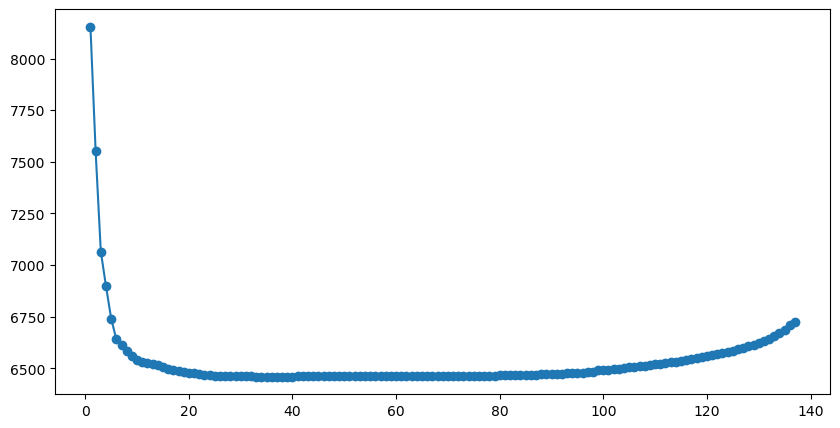

In [21]:
plt.figure(figsize=(10,5))
plt.plot(results_selection["num_features"], results_selection["scores"], marker="o");

The results show that the lowest error is achieved with 39 features, which is why this subset of features was chosen in the further course of the analysis. However, the graph shows that the number of features could be reduced even further without a great loss of performance and that comparatively good predictions can be generated with only the 5 to 10 most important features.

Finally, a second round of hyperparameter tuning is performed, since it is possible that the model can also get by with less regularization after feature selection.

In [22]:
selected = results_selection.loc[results_selection["scores"].idxmin():, "last_features"].tolist()
cols = [col for col in X.columns if col in selected ]

onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

target_encoding = Pipeline([
    ("te", TargetEncoder()),
    ("scaler", StandardScaler())
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": list(range(1, 10)),
               "model__regressor__alpha": np.arange(1e-5, 1e-3, 1e-5)},
              {"encoder": [target_encoding],
               "encoder__te__smoothing": [0.1, 0.5, 1.0, 5.0, 10., 20.],
               "model__regressor__alpha": np.arange(1e-5, 1e-3, 1e-5)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X[cols], y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5165.752862766009
test score: 6455.188039706135


{'model__regressor__alpha': 0.00015000000000000001,
 'encoder__ohe__min_frequency': 1,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe',
                  OneHotEncoder(drop='if_binary', handle_unknown='ignore'))])}

## Performance on Test Data

In [23]:
X_test = df_test.drop(["average_salary"], axis=1)
y_test = df_test["average_salary"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ("model", TransformedTargetRegressor(Lasso(alpha=0.00015), func=np.log, inverse_func=np.exp))
])

pipe.fit(X[cols], y)
predictions = pipe.predict(X_test[cols])
print(f"Mean Absolute Error on Test Set: {mean_absolute_error(y_test, predictions)}")

Mean Absolute Error on Test Set: 6364.766339297125


The performance of the model can also be confirmed on the test data. The fact that the performance here is even better than on the validation data is actually relatively rare and in this case is most likely due to the relatively small amount of data in the test data.

In [24]:
import joblib

joblib.dump(pipe, "../models/model.joblib")

['../models/model.joblib']

<a id="interpretation"></a>

## Interpretation

Finally, we analyze how the model makes its predictions. For this purpose, two aspects are examined:

- Which features contribute most to the performance of the model? ==> Drop column feature importances
- Which categories have the most impact on the salary of a job? ==> Coefficients of the regression

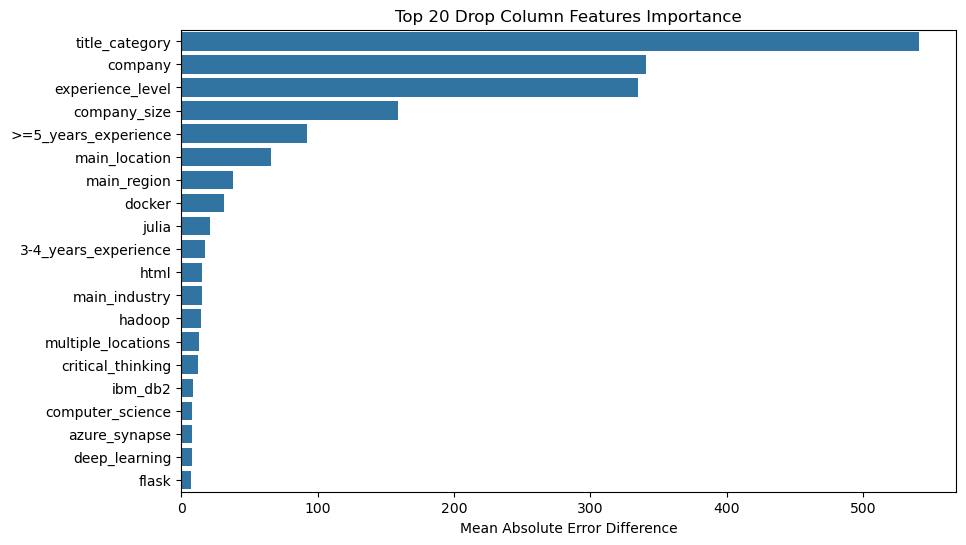

In [25]:
X2 = X[cols].copy()

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", TransformedTargetRegressor(Lasso(alpha=0.00015), func=np.log, inverse_func=np.exp))
])

kfold = KFold(5)
diffs = defaultdict(list)
for train_idx, val_idx in kfold.split(X2):
    X_train = X2.iloc[train_idx]
    X_val = X2.iloc[val_idx]
    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    baseline = mean_absolute_error(y_val, preds)

    for col in X2.columns:
        pipe.fit(X_train.drop(col, axis=1), y_train)
        preds = pipe.predict(X_val.drop(col, axis=1))
        mae = mean_absolute_error(y_val, preds)
        diffs[col].append(mae-baseline)

importances = pd.DataFrame(diffs).T.mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title("Top 20 Drop Column Features Importance")
plt.ylabel("")
plt.xlabel("Mean Absolute Error Difference");

As expected, the job title, the experience level, the company itself, the size of the company and the location have the greatest impact on the salary. The specific skills required in a job advertisement play only a comparatively minor role.

Next, the coefficients of the model are interpreted.

In [26]:
imputer = SimpleImputer(strategy="constant", fill_value="missing_value")
imputer.set_output(transform="pandas")

pipe = Pipeline([
    ("imputer", imputer),
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ("model", TransformedTargetRegressor(Lasso(alpha=0.00015), func=np.log, inverse_func=np.exp))
])

pipe.fit(X[cols], y)

coefficients = (np.exp(pipe["model"].regressor_.coef_)-1)*100
importances = pd.DataFrame({"feature": pipe["encoder"].get_feature_names_out(), "coefficient": coefficients})
importances.sort_values("coefficient", ascending=False, key=lambda x: np.abs(x)).head()

,feature,coefficient
159,company_Elmar Hertzog und Partner Management C...,97.520495
168,company_Evotec SE,92.147659
539,company_ifp | Personalberatung Managementdiagn...,60.990502
260,company_JLL,35.941350
143,company_Dr. Werner Freyberg Chemische Fabrik D...,32.190200


Normally, the coefficients of a regression indicate by how many units the target changes when a certain feature is increased by one unit. However, due to the log transformation, this method of interpretation is no longer possible. Instead, however, a percentage effect on the target can be read off via the performed transformation.

A first overview shows that the largest coefficients of the model are mainly specific company names. While it is certainly interesting to know which companies pay the highest salaries, this analysis will focus primarily on somewhat more general factors.

In [27]:
importances.loc[importances["feature"].str.contains("title_category_")].sort_values("coefficient", ascending=False)

,feature,coefficient
588,title_category_Data Science Manager,7.560246
589,title_category_Data Scientist,4.328188
586,title_category_Data Engineer,1.271195
590,title_category_Machine Learning Engineer,0.000000
587,title_category_Data Science Consultant,-3.016480
591,title_category_Software Engineer,-4.587394
585,title_category_Data Analyst,-5.228076


In [28]:
importances.loc[importances["feature"].str.contains("experience_level_")].sort_values("coefficient", ascending=False)

,feature,coefficient
594,experience_level_Senior,6.229839
593,experience_level_No Information,0.000000
592,experience_level_Junior,-13.742870


In [29]:
importances.loc[importances["feature"].str.contains("company_size_")].sort_values("coefficient", ascending=False)

,feature,coefficient
576,"company_size_10,001+",8.500206
580,"company_size_5001-10,000",8.236335
578,company_size_2501-5000,2.252807
583,company_size_missing_value,1.614784
581,company_size_501-1000,0.000000
577,company_size_1001-2500,-1.123785
579,company_size_251-500,-2.692364
575,company_size_0-50,-4.357577
582,company_size_51-250,-5.075108


In [30]:
importances.loc[importances["feature"].str.contains("main_region_")].sort_values("coefficient", ascending=False)

,feature,coefficient
787,main_region_Hesse,5.215382
782,main_region_Baden-Württemberg,4.288235
786,main_region_Hamburg,1.561002
783,main_region_Bavaria,0.944355
784,main_region_Berlin,0.458353
785,main_region_Brandenburg,0.000000
789,main_region_Mecklenburg-Vorpommern,0.000000
790,main_region_North Rhine-Westphalia,0.000000
794,main_region_Saxony-Anhalt,0.000000
796,main_region_Thuringia,0.000000


In [31]:
importances.loc[importances["feature"].str.contains("main_industry_")].sort_values("coefficient", ascending=False)

,feature,coefficient
818,main_industry_Medizintechnik,11.390580
802,main_industry_Chemie- und Erdölverarbeitende I...,8.509955
816,main_industry_Maschinen- und Anlagenbau,5.980505
799,main_industry_Banken,5.513913
822,main_industry_Pharmaindustrie,4.160888
806,main_industry_Finanzdienstleister,3.170099
804,main_industry_Energie- und Wasserversorgung & ...,2.835687
829,"main_industry_Unternehmensberatg., Wirtschafts...",2.153241
830,main_industry_Versicherungen,1.676221
812,main_industry_IT & Internet,1.231782


<a id="summary"></a>

## Summary

With the model found, it was possible to reduce the mean absolute error of salary forecasts by 3000 euros. Nevertheless, the remaining error is still more than 6000 euros. All the features that Stepstone includes in its description of its machine learning model were also included in this model. The rules for extracting job titles, different skills, or work experience were made to the best of my ability. However, it is quite possible that Stepstone used a slightly different approach when extracting these information and may have evaluated other keywords as well. From the location information, only the states were additionally extracted in the context of this model with the help of an API. Here, one could possibly include other features such as population figures of the cities.

The most likely reason for the poorer results is the insufficient amount of data. In the context of the EDA it became clear that some relationships to the target are still very distorted due to the too small sample (e.g. highest average salary in Thuringia). Most of the relationships in the model make sense in principle, but are still relatively subject to noise. For example, there is no monotonic dependence between salary and company size in the data used. A larger data set would help to minimize this noise in the data and better represent the true relationships. Also, the error obtained on the test data is relatively imprecise at the moment and would also benefit from a larger data set.

Finally, it should also be mentioned that the values of the target are also in the predictions of a model and not real salaries. Attributes with Python, R or SQL, which hardly make a difference in the context of this analysis, could possibly be important for an analysis specifically designed for Data Science jobs.